In [1]:
"""Scripts for analyzing of phantom outputs.

This script writes hdf5 files for each dump (and one hdf5 file synthsizing all outputs)
    to plot photosphere size vs time or orbital separation.
It does so by plotting photosphere intersection with traced rays originating from the primary star
    and shooting along the axes of the coordination frame.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script writes hdf5 files for each dump (and one hdf5 file synthsizing all outputs)\n    to plot photosphere size vs time or orbital separation.\nIt does so by plotting photosphere intersection with traced rays originating from the primary star\n    and shooting along the axes of the coordination frame.\n\n'

In [2]:
from os.path import sep

import numpy as np
from scipy.optimize import root_scalar
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants as const

import sarracen as sar
import clmuphantomlib as mupl
from clmuphantomlib import set_as_quantity

from _photosphere_jobProfiles__input import JOB_PROFILES_DICT, out_dir
out_dir += "20250925_new-dumps-profile/"

In [3]:
plt.rcParams.update({'font.size': 20})

## Write clmu_2mdc

In [15]:
nn = '4md'

In [16]:
def read_mesa_data_AGB(
    filename = '../dustystar/AGB_th.data',
):
    mesa_data = np.loadtxt(
        filename, skiprows=6,
        usecols=(2, 3, 4, 9, 10, 11, 12, 19),
        dtype=[
            ('log10_R1', np.double),
            ('log10_T', np.double),
            ('log10_rho', np.double),
            ('R1_cm', np.double),
            ('mass_g', np.double),
            ('temp', np.double),
            ('rho', np.double),
            ('lum', np.double)],
    )
    stuff_mesa = {
        'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
        'T' : mesa_data['temp'] * units.K,
        'lum' : mesa_data['lum'] * units.Lsun,
        'rho' : mesa_data['rho'] * (units.g/units.cm**3),
    }
    return stuff_mesa

def read_mesa_data_4md(
    filename = '../dustystar/profile2568.data',
):
    mesa_data = np.loadtxt(
        filename, skiprows=6,
        usecols=(2, 3, 8, 12, 14, 38),
        dtype=[
            ('log10_R1', np.double),
            ('log10_T', np.double),
            ('R1_cm', np.double),
            ('temp', np.double),
            ('rho', np.double),
            ('lum', np.double)],
    )
    stuff_mesa = {
        'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
        'T' : mesa_data['temp'] * units.K,
        'lum' : mesa_data['lum'] * units.Lsun,
        'rho' : mesa_data['rho'] * (units.g/units.cm**3),
    }
    return stuff_mesa

if nn in {'2md'}:
    stuff_mesa = read_mesa_data_AGB()
elif nn in {'4md'}:
    stuff_mesa = read_mesa_data_4md()
else:
    raise NotImplementedError

#### Note

Adiabatic EOS:

$$ P = (\gamma - 1) \rho u $$

(u is specific internal energy)

Also ideal Gas

$$ P = \frac{N k_B}{V} T $$

So

$$ T = (\gamma - 1) \frac{\rho V}{N k_B} u = (\gamma - 1) \frac{\mu m_p}{k_B} u $$

And

$$ u = \frac{k_B}{(\gamma - 1) \mu m_p} T $$

In [17]:
def read_clmu_2mdc(
    fp,  # =f"../raw/clmu_{nn}c/"
    stuff_mesa = stuff_mesa,
    keep_outside_mesa_R_pts: bool = False, 
):
    
    mpdf = mupl.MyPhantomDataFrames().read(f"{fp}light", 0)

    # rescale u and temperature
    sdf = mpdf.data['gas']
    sdf_old = sdf.copy()
    R0x, R0y, R0z = mpdf.data['sink'][['x', 'y', 'z']].iloc[0]
    R1s = np.sqrt((sdf['x']-R0x)**2 + (sdf['y']-R0y)**2 + (sdf['z']-R0z)**2)

    mesa_R1s = stuff_mesa['R1'].to_value(mpdf.units['dist'])[::-1]
    mesa_Ts  = stuff_mesa['T' ].to_value(mpdf.units['temp'])[::-1]
    Ts = set_as_quantity(np.interp(R1s, mesa_R1s, mesa_Ts), units.K)
    # us = (    # use adiabatic eos as approximation to get u
    #     const.k_B
    #     / ((mpdf.params['gamma'] - 1)
    #     * set_as_quantity(sdf['mu'], units.u)) * Ts
    # ).cgs

    # Warning: directly change mpdf.data may lead to undefined behaviour
    #    as it doesn't alter mpdf.sdfs
    mk_s = (R1s >= 0) if keep_outside_mesa_R_pts else (R1s <= mesa_R1s[-1])    # save
    mk_c = (100 <= R1s) & mk_s      # change

    sdf.loc[mk_c, 'temperature'] = Ts[mk_c].to_value(mpdf.units['temp'])
    # sdf.loc[mk_c, 'u'] = us[mk_c].to_value(mpdf.units['specificEnergy'])
    sdf.loc[~mk_s, 'h'] *= -1    # disable outmost particles
    
    # mpdf.data['gas'] = sdf[mk_s]
    # R1s = R1s[mk_s]
    # Ts = Ts[mk_s]
    # # us = us[mk_s]

    # Ts_new = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u'))
    
    return mpdf, sdf_old, mk_s, mk_c, R1s, Ts
    
mpdf, sdf_old, mk_s, mk_c, R1s, Ts = read_clmu_2mdc(fp=f"../raw/clmu_{nn}c/", keep_outside_mesa_R_pts=False)
sdf = mpdf.data['gas']

*   Note   :    <module>() ==> read_clmu_2mdc() ==> read():
	

	Reading filename='../raw/clmu_4mdc/light_00000'


**  Warning:    <module>() ==> read_clmu_2mdc() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


#### Note

EOS table E & V range:

$$E = \log_{10}{u} \in [10, 17]$$

$$V = 20 + \log_{10}{\rho} - 0.7 \log_{10}{u} \in [-10, 14]$$

$$\log_{10}{u} = \frac{20 + \log_{10}{\rho} - V}{0.7} \in [(6+\log_{10}{\rho})/0.7, (30+\log_{10}{\rho})/0.7]$$


In [18]:
EOS = mupl.get_eos(10, JOB_PROFILES_DICT[nn]['params'])
eos = EOS
def get_u_from_rhoT(
    mpdf,
    mask,
    rhos = None,
    Ts = None,
    eos = EOS,
    bracket_E = (10.1, 16.9),
    do_update_mpdf: bool = False,
    save_fp: None|str = None,
):
    """Calc u from rho and T"""

    if rhos is None: rhos = mpdf.get_val('rho')
    rhos = rhos[mask]
    if Ts   is None: Ts   = mpdf.get_val('T')
    Ts = Ts[mask]
    # Using Brentq to find u
    #    see help(optimize.brentq)
    
    log10_us_ans = [
        root_scalar(    # find u by root-finding
            lambda log10_u: eos.get_val_cgs('T', rho=rho, u=10**log10_u, verbose=False) - T,
            method='brentq', bracket=bracket_E, rtol=1e-8,
        ) if np.prod(eos.get_val_cgs(    # verify if braket contains both sides
            'T', rho=(rho, rho), u=(10**bracket_E[0], 10**bracket_E[1]), verbose=False
        ) - T) < 0 else None
        for rho, T in zip(rhos.cgs.value, Ts.cgs.value)
    ]
    us_mk = set_as_quantity(
        np.array([10**ans.root if ans is not None else np.nan for ans in log10_us_ans]), (units.erg/units.g)
    )
    us = mpdf.get_val('u').cgs
    us[mask] = np.where(np.isnan(us[mask]), us[mask], us_mk)
    if save_fp:
        np.save(save_fp, us.cgs.value)
    if do_update_mpdf:
        mpdf.data['gas'].loc[:, 'u'] = us
    return us, log10_us_ans

In [19]:
REDO_U_CALC = False
init_u_fp = f"..{sep}raw{sep}clmu_{nn}c{sep}init_u_cgs.npy"

mask = mk_c #[mk_s]
if REDO_U_CALC:
    us, log10_us_ans = get_u_from_rhoT(
        mpdf, mask, Ts=Ts, do_update_mpdf=False,
        save_fp=init_u_fp)
else:
    us = np.load(init_u_fp) * (units.erg/units.g)
    # raise NotImplementedError

In [20]:
def moddump_comp_loc(
    sdf,
    sdf_sink,
    comp_loc_frac: float,
    mask_kill : np.ndarray[bool],
    vs_innate : np.ndarray[float],
    R0: float,
    G: float,
    use_proper_gas_velocity: bool = True,
):
    """Change companion location to {comp_loc_frac} of its original """
    # dump with companion star at half way
    sdf_sink_new = sdf_sink.copy()
    sdf_new = sdf.copy()
    sdf_sink_new.loc[1, ['x', 'y', 'z']] -= (
        sdf_sink_new.loc[1, ['x', 'y', 'z']] - sdf_sink_new.loc[0, ['x', 'y', 'z']] - np.array([R0, 0, 0])
    ) * (1 - comp_loc_frac)
    #    reset center of mass
    ms = np.hstack((sdf_sink_new['m'], np.full(len(sdf_new[~mask_kill]), sdf_new.params['massoftype'])))
    rs = np.vstack((sdf_sink_new[['x', 'y', 'z']], sdf_new.loc[~mask_kill, ['x', 'y', 'z']]))
    m_tot = np.sum(ms)    # incl. ptmass
    r0 = np.sum(ms[:, np.newaxis] * rs, axis=0) / m_tot
    sdf_sink_new.loc[:, ['x', 'y', 'z']] -= r0
    sdf_new.loc[:, ['x', 'y', 'z']] -= r0
    #    reset velocity from rotation
    D = np.abs(sdf_sink_new.loc[0, 'x'] - sdf_sink_new.loc[1, 'x'])
    omega = np.sqrt(G * m_tot / D**3)
    #    v = w \times r (vector cross product)
    sdf_new.loc[:, ['vx', 'vy', 'vz']] = vs_innate
    sdf_new['vx'] -= omega * (sdf_new['y'] if use_proper_gas_velocity else sdf_sink_new['y'][0])
    sdf_new['vy'] += omega * (sdf_new['x'] if use_proper_gas_velocity else sdf_sink_new['x'][0])

    sdf_sink_new.loc[:, 'vx'] = -omega * sdf_sink_new['y']
    sdf_sink_new.loc[:, 'vy'] = omega * sdf_sink_new['x']
    sdf_sink_new.loc[:, 'vz'] = 0

    return sdf_new, sdf_sink_new

In [26]:
def write_clmu_2md_sims(
    nn: str,
    us_value: np.ndarray[float],
    mask_kill: np.ndarray[bool],
    R0: float,    # donor star radius in phantom code units
                  # assumes donor/companion on x axis
    fp = "../raw/",
    G  = 1.,  # gravitational constant in code units
    dry_run = False,
):
    """write modded sims to disk

    Specific to my scenarios
    """
    sdf, sdf_sink = sar.read_phantom(   f"{fp}{sep}luis_{nn}{sep}light_00000")

    # normal dump with fixed u
    sdf.loc[:, 'gamma'] = sdf.params['gamma']
    #    delete params to force phantom to recalculate them
    del sdf.params['etot_in']
    del sdf.params['angtot_in']
    del sdf.params['totmom_in']
    sdf_old = sdf.copy()

    # kill dead particles
    sdf.loc[:, 'u'] = us_value
    #sdf.loc[mask_kill, 'h'] = -np.abs(sdf.loc[mask_kill, 'h'])
    sdf = sdf.loc[~mask_kill]
    mask_kill = sdf['h'] <= 0
    nparttot = len(sdf)
    sdf.params['nparttot'] = np.int32(nparttot)
    sdf.params['nparttot_2'] = np.int64(nparttot)
    sdf.params['npartoftype'] = np.int32(nparttot)
    sdf.params['npartoftype_9'] = np.int64(nparttot)    # don't know why it's also npart but whatev
    
    if not dry_run:
        # c for cleaned up
        sar.write_phantom(f"{fp}{sep}clmu_{nn}c{sep}lumo_00000.tmp", sdf, sdf_sink)

    # dump with donor star only
    #    Important: use iloc instead of loc because pandas dataframe behave funny with indexes and such
    sdf_sink_new = sdf_sink.iloc[:1].copy()
    sdf_new = sdf.copy()
    r0 = sdf_sink.loc[0, ['x', 'y', 'z']]
    v0 = sdf_sink.loc[0, ['vx', 'vy', 'vz']]
    sdf_sink_new.loc[:, ['x', 'y', 'z']] -= r0
    sdf_sink_new.loc[:, ['vx', 'vy', 'vz']] -= v0
    sdf_new.loc[:, ['x', 'y', 'z']] -= r0
    sdf_new.loc[:, ['vx', 'vy', 'vz']] -= v0
    vs_innate = sdf_new.loc[:, ['vx', 'vy', 'vz']]
    if not dry_run:
        # d for donor
        sar.write_phantom(f"{fp}{sep}clmu_{nn}d{sep}lumo_00000.tmp", sdf_new, sdf_sink_new)

    # dump with donor star only
    #    Important: use iloc instead of loc because pandas dataframe behave funny with indexes and such
    #    Original luis version
    sdf_sink_new = sdf_sink.iloc[:1].copy()
    sdf_new = sdf_old.copy()
    r0 = sdf_sink.loc[0, ['x', 'y', 'z']]
    v0 = sdf_sink.loc[0, ['vx', 'vy', 'vz']]
    sdf_sink_new.loc[:, ['x', 'y', 'z']] -= r0
    sdf_sink_new.loc[:, ['vx', 'vy', 'vz']] -= v0
    sdf_new.loc[:, ['x', 'y', 'z']] -= r0
    sdf_new.loc[:, ['vx', 'vy', 'vz']] -= v0
    if not dry_run:
        # d for donor
        sar.write_phantom(f"{fp}{sep}clmu_{nn}do{sep}lumo_00000.tmp", sdf_new, sdf_sink_new)

    sdf_new, sdf_sink_new = moddump_comp_loc(
        sdf, sdf_sink, comp_loc_frac=0.5, mask_kill=mask_kill, vs_innate=vs_innate, R0=R0, G=G,
    )
    if not dry_run:
        # h for halfway
        sar.write_phantom(f"{fp}{sep}clmu_{nn}h{sep}lumo_00000.tmp", sdf_new, sdf_sink_new)

    sdf_new, sdf_sink_new = moddump_comp_loc(
        sdf, sdf_sink, comp_loc_frac=0.0, mask_kill=mask_kill, vs_innate=vs_innate, R0=R0, G=G,
    )
    if not dry_run:
        # s for surface
        sar.write_phantom(f"{fp}{sep}clmu_{nn}s{sep}lumo_00000.tmp", sdf_new, sdf_sink_new)

    sdf_new, sdf_sink_new = moddump_comp_loc(
        sdf, sdf_sink, comp_loc_frac=0.0, mask_kill=mask_kill, vs_innate=vs_innate, R0=R0, G=G,
        use_proper_gas_velocity = False,
    )
    if not dry_run:
        # s for surface
        sar.write_phantom(f"{fp}{sep}clmu_{nn}sv{sep}lumo_00000.tmp", sdf_new, sdf_sink_new)
    
    return sdf, sdf_sink, sdf_new, sdf_sink_new


R0 = stuff_mesa['R1'][0].to_value(mpdf.units['dist'])
print(f"\n\t{R0 = }")
sdf_old, sdf_sink_old, sdf_new, sdf_sink_new = write_clmu_2md_sims(
    nn = nn,
    us_value = us.to_value(mpdf.units['specificEnergy']),
    R0 = R0,
    mask_kill= ~mk_s,
    dry_run = False,
)
sdf

*   Note   :    <module>() ==> write_clmu_2md_sims() ==> read():
	

	Reading filename='../raw//luis_4md/light_00000'


**  Warning:    <module>() ==> write_clmu_2md_sims() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])

	R0 = np.float64(330.76289135720253)


,iorig,x,y,z,temperature,gamma,vx,vy,vz,u,...,S,kappa,alphw,Tdust,h,alpha,divv,poten,R1,rho
0,1,81.340307,-47.339907,89.274002,54044.961679,1.666667,-0.000879,-0.015898,-0.000076,0.013472,...,0.0,0.0,0.0,54044.961679,4.391748,1.0,-0.000048,-1.847562e-08,162.529917,4.479580e-08
1,2,-173.293560,47.590553,-89.276948,54017.664531,1.666667,-0.000275,-0.015800,0.000256,0.013463,...,0.0,0.0,0.0,54017.664531,4.389516,1.0,0.000009,-1.846554e-08,162.632658,4.486418e-08
2,3,-99.631230,-23.991940,19.568047,132788.290578,1.666667,-0.000401,-0.015805,-0.000309,0.023369,...,0.0,0.0,0.0,132788.290578,2.619342,1.0,0.000002,-2.715037e-08,61.964932,2.111412e-07
3,4,8.515117,24.320975,-19.916545,131263.344470,1.666667,-0.000020,-0.015432,0.000301,0.023176,...,0.0,0.0,0.0,131263.344470,2.629902,1.0,-0.000005,-2.706462e-08,62.890204,2.086081e-07
4,5,-100.912254,92.999148,-146.988812,47503.219297,1.666667,0.000295,-0.016488,-0.000106,0.012218,...,0.0,0.0,0.0,47503.219297,4.976148,1.0,-0.000007,-1.703756e-08,182.410378,3.079426e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372083,1372084,-67.944067,-2.174226,1.379239,252735.933942,1.666667,0.000190,-0.015741,0.000420,0.039349,...,0.0,0.0,0.0,252735.933942,1.816174,1.0,-0.000017,-3.103675e-08,22.138898,6.333993e-07
1372084,1372085,-124.587777,-8.419416,-84.872157,79577.180168,1.666667,0.000203,-0.015183,0.000424,0.017030,...,0.0,0.0,0.0,79577.180168,3.430905,1.0,-0.000013,-2.225279e-08,115.998885,9.395578e-08
1372085,1372086,32.156910,7.992239,84.745196,80047.966780,1.666667,-0.001216,-0.015563,0.000095,0.017071,...,0.0,0.0,0.0,80047.966780,3.424553,1.0,-0.000016,-2.229409e-08,115.536268,9.447955e-08
1372086,1372087,-59.567913,190.491841,-169.847440,20763.404214,1.666667,-0.001463,-0.014073,-0.001134,0.008122,...,0.0,0.0,0.0,20763.404214,7.890719,1.0,0.000039,-1.285343e-08,255.578054,7.723248e-09


    def write_clmu_4mddo_sim(
        nn,
        fp = "../raw/",
        dry_run = False,
    ):
        """write modded 4mddo sim to disk
    
        Specific to my scenarios
        """
        sdf, sdf_sink = sar.read_phantom(f"{fp}{sep}luis_4md{sep}light_00000")
    
        # normal dump with fixed u
        sdf.loc[:, 'gamma'] = sdf.params['gamma']
        #    delete params to force phantom to recalculate them
        del sdf.params['etot_in']
        del sdf.params['angtot_in']
        del sdf.params['totmom_in']
        sdf_old = sdf.copy()
    
        # dump with donor star only
        #    Important: use iloc instead of loc because pandas dataframe behave funny with indexes and such
        #    Original luis version
        sdf_sink_new = sdf_sink.iloc[:1].copy()
        sdf_new = sdf_old.copy()
        r0 = sdf_sink.loc[0, ['x', 'y', 'z']]
        v0 = sdf_sink.loc[0, ['vx', 'vy', 'vz']]
        sdf_sink_new.loc[:, ['x', 'y', 'z']] -= r0
        sdf_sink_new.loc[:, ['vx', 'vy', 'vz']] -= v0
        sdf_new.loc[:, ['x', 'y', 'z']] -= r0
        sdf_new.loc[:, ['vx', 'vy', 'vz']] -= v0
        if not dry_run:
            # d for donor
            sar.write_phantom(f"{fp}{sep}clmu_{nn}do{sep}lumo_00000.tmp", sdf_new, sdf_sink_new)
        
        return sdf, sdf_sink, sdf_new, sdf_sink_new
    
    # sdf, sdf_sink, sdf_new, sdf_sink_new = write_clmu_4mddo_sim(
    #     nn,
    #     dry_run = False,
    # )
    # sdf

### Plotting for Paper

In [21]:
print(nn)

mpdf = mupl.MyPhantomDataFrames().read(f"../raw/clmu_{nn}d/lumo", 0, calc_params=['R1'])
sdf = mpdf.data['gas']

mpdf_origin = mupl.MyPhantomDataFrames().read(JOB_PROFILES_DICT[nn]['job_name'], 0, calc_params=['R1'])
# sdf = sdf_new
# sdf_sink = sdf_sink_new
# sdf['R1'] = ((sdf['x']-sdf_sink.loc[0, 'x'])**2+(sdf['y']-sdf_sink.loc[0, 'y'])**2+(sdf['z']-sdf_sink.loc[0, 'z'])**2)**0.5
# sdf.calc_density()

4md
*   Note   :    run_code() ==> <module>() ==> read():
	

	Reading filename='../raw/clmu_4mdd/lumo_00000'


**  Warning:    run_code() ==> <module>() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
*   Note   :    run_code() ==> <module>() ==> read():
	

	Reading filename='../raw/luis_4md/light_00000'


**  Warning:    run_code() ==> <module>() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units

Saved to ../fig/20250925_new-dumps-profile/T-vs-R1_4mdd_00000.png


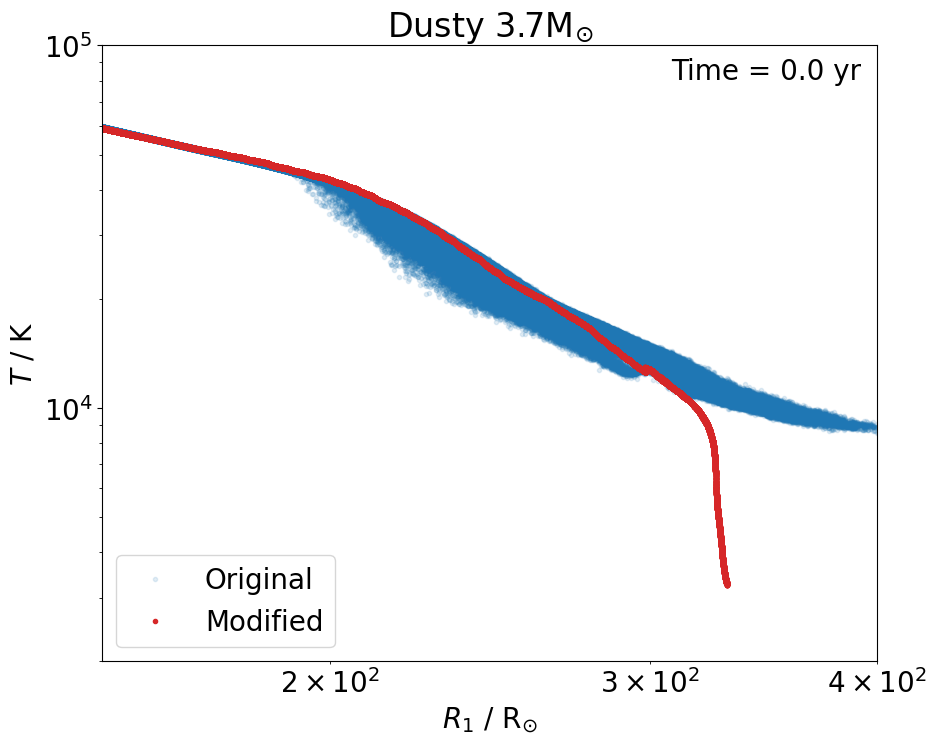

In [22]:
# after

xlim = (90, 300) if nn in {'2md'} else (150, 400)
ylim = (2000, 1e5)

mk_p = sdf['R1'] > 10
mk_m = stuff_mesa['R1'] > 10 * units.Rsun
fig, ax = plt.subplots(figsize=(10, 8))

ax.loglog(mpdf_origin.get_val('R1'), mpdf_origin.get_val('temperature').cgs, '.', alpha=1/8, label=f"Original")
ax.loglog(sdf['R1'][mk_p], mpdf.get_val('temperature').cgs[mk_p], '.', color='C3', label=f"Modified")
# ax.loglog(sdf['R1'][mk_p], eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).cgs[mk_p], '.')
# ax.loglog(stuff_mesa['R1'][mk_m], stuff_mesa['T'][mk_m], linewidth=2, color='C1', label=f"MESA")

ax.text(
    0.98, 0.98, f"Time = {mpdf.get_time()}",
    ha = 'right', va = 'top', transform=ax.transAxes,
)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(f"$R_1$ / {stuff_mesa['R1'].unit.to_string('latex')}")
ax.set_ylabel(f"$T$ / {stuff_mesa['T'].unit.to_string('latex')}")
ax.legend(loc='lower left')

ax.set_title(f"{JOB_PROFILES_DICT[nn]['name']}")

out_filename = f"{out_dir}T-vs-R1_{nn}d_00000.png"
fig.savefig(out_filename)
print(f"Saved to {out_filename}")

### Test

2md
*   Note   :    run_code() ==> <module>() ==> read():
	

	Reading filename='../raw/clmu_2mdd/lumo_00000'


**  Warning:    run_code() ==> <module>() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


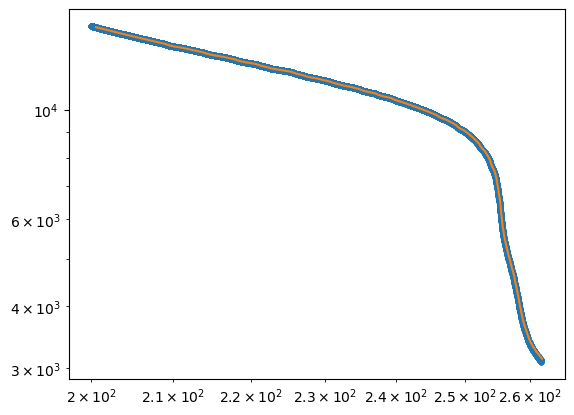

In [7]:
print(nn)

mpdf = mupl.MyPhantomDataFrames().read(f"../raw/clmu_{nn}d/lumo", 0, calc_params=['R1'])
sdf = mpdf.data['gas']
# sdf = sdf_new
# sdf_sink = sdf_sink_new
# sdf['R1'] = ((sdf['x']-sdf_sink.loc[0, 'x'])**2+(sdf['y']-sdf_sink.loc[0, 'y'])**2+(sdf['z']-sdf_sink.loc[0, 'z'])**2)**0.5
# sdf.calc_density()
mk_p = sdf['R1'] > 200
mk_m = stuff_mesa['R1'] > 200 * units.Rsun
# plt.loglog(sdf['R1'][mk_p], set_as_quantity(sdf['temperature'], mpdf.units['temp']).cgs[mk_p], '.')
plt.loglog(sdf['R1'][mk_p], eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).cgs[mk_p], '.')
plt.loglog(stuff_mesa['R1'][mk_m], stuff_mesa['T'][mk_m])

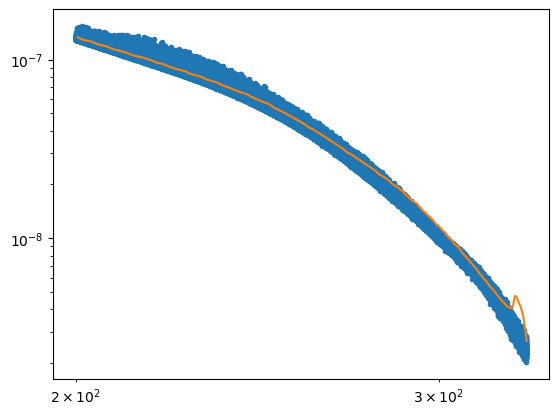

In [52]:
plt.loglog(sdf['R1'][mk_p],set_as_quantity(sdf['rho'], mpdf.units['density']).cgs[mk_p], '.')
plt.loglog(stuff_mesa['R1'][mk_m], stuff_mesa['rho'][mk_m])

In [106]:
emt = mupl.eos.mesa._EoS_MESA_table(JOB_PROFILES_DICT['2md']['params'], mupl.DEFAULT_SETTINGS)
print(emt._log10_E_arr, '\n\n', emt._log10_V_arr)

[10.         10.05882353 10.11764706 10.17647059 10.23529412 10.29411765
 10.35294118 10.41176471 10.47058824 10.52941176 10.58823529 10.64705882
 10.70588235 10.76470588 10.82352941 10.88235294 10.94117647 11.
 11.05882353 11.11764706 11.17647059 11.23529412 11.29411765 11.35294118
 11.41176471 11.47058824 11.52941176 11.58823529 11.64705882 11.70588235
 11.76470588 11.82352941 11.88235294 11.94117647 12.         12.05882353
 12.11764706 12.17647059 12.23529412 12.29411765 12.35294118 12.41176471
 12.47058824 12.52941176 12.58823529 12.64705882 12.70588235 12.76470588
 12.82352941 12.88235294 12.94117647 13.         13.05882353 13.11764706
 13.17647059 13.23529412 13.29411765 13.35294118 13.41176471 13.47058824
 13.52941176 13.58823529 13.64705882 13.70588235 13.76470588 13.82352941
 13.88235294 13.94117647 14.         14.05882353 14.11764706 14.17647059
 14.23529412 14.29411765 14.35294118 14.41176471 14.47058824 14.52941176
 14.58823529 14.64705882 14.70588235 14.76470588 14.8235294

In [107]:
np.max(emt._table_noZX['log10_T'])

np.float64(8.637891319511455)

In [108]:
mpdf.get_val('u').cgs

<Quantity [1.33212470e+01, 1.33205771e+01, 3.93581492e+13, ...,
           2.65236987e+13, 1.50108923e+01, 1.51284886e+01] cm2 / s2>

In [109]:
np.count_nonzero(np.isnan(Ts_new))

693634

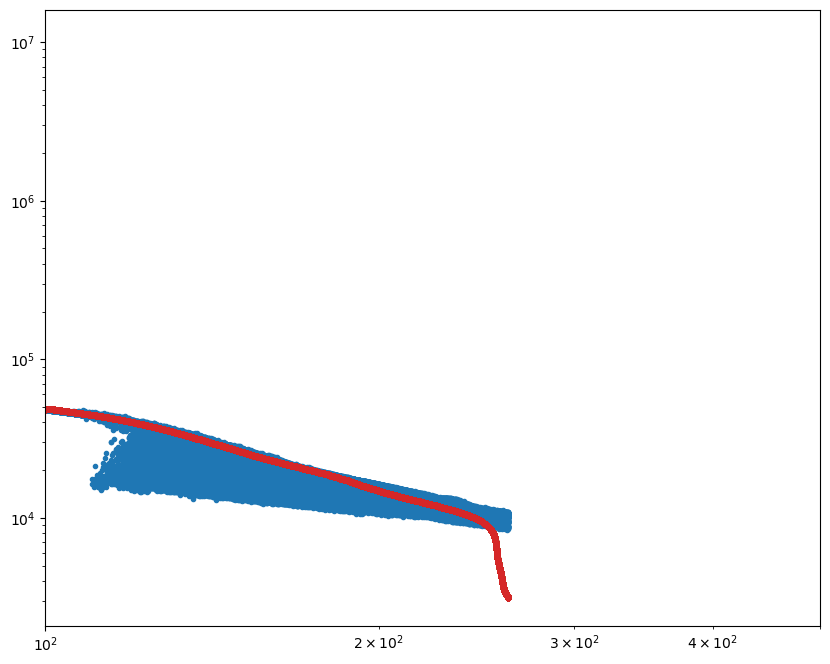

In [127]:
if __name__ == '__main__':
    Ts_new = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u'))
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(R1s, sdf_old['temperature'][mk_s], '.')
    ax.loglog(R1s, mpdf.get_val('temperature'), '.')
    ax.loglog(R1s, Ts, '.')
    ax.loglog(R1s, Ts_new, '.')
    ax.set_xlim(100, 500)
    # ax.set_ylim(1e3, 1e5)

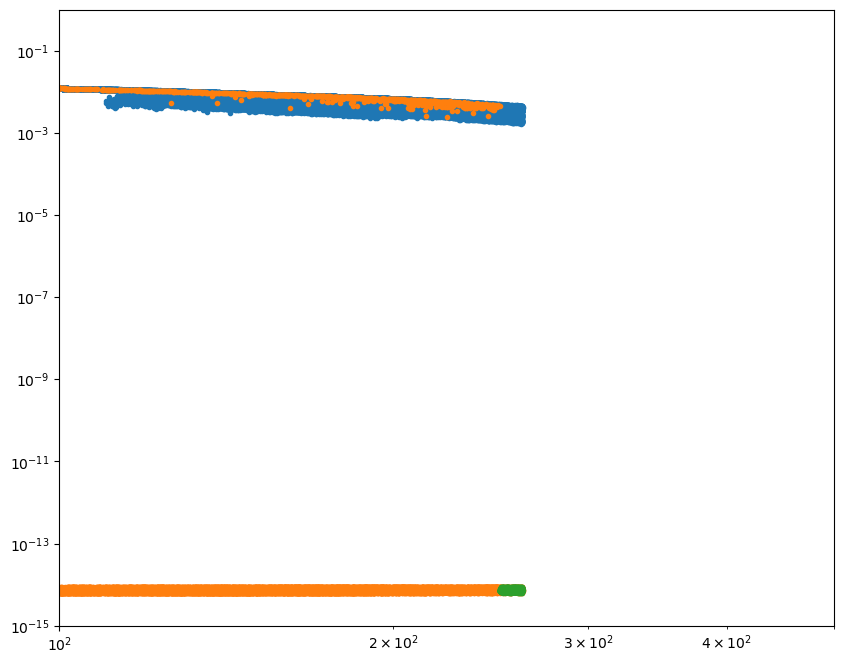

In [88]:
if __name__ == '__main__':
    Ts_new = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u'))
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(R1s, sdf_old['u'][mk_s], '.')
    ax.loglog(R1s, mpdf.get_val('u'), '.')
    ax.loglog(R1s[mk_z], us.to(mpdf.units['specificEnergy']), '.')
    ax.set_xlim(100, 500)
    ax.set_ylim(1e-15, 1e0)

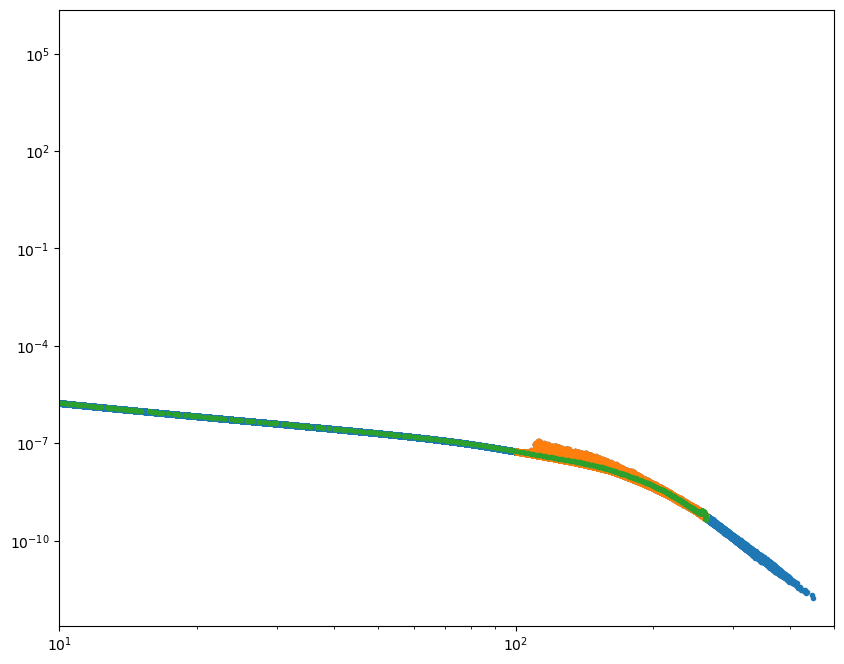

In [20]:
if __name__ == '__main__':
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(R1s, sdf_old['rho'], '.')
    ax.loglog(R1s[mk_c], mpdf.get_val('rho')[mk_c[mk_s]], '.')
    ax.loglog(stuff_mesa['R1'], stuff_mesa['rho'].to(mpdf.units['density']), '.')
    ax.set_xlim(10, 500)
    # ax.set_ylim(1e3, 1e5)

In [37]:
eos = EOS
eos._EoS_MESA__mesa_table._interp_dict['log10_T'].grid

(array([10.        , 10.05882353, 10.11764706, 10.17647059, 10.23529412,
        10.29411765, 10.35294118, 10.41176471, 10.47058824, 10.52941176,
        10.58823529, 10.64705882, 10.70588235, 10.76470588, 10.82352941,
        10.88235294, 10.94117647, 11.        , 11.05882353, 11.11764706,
        11.17647059, 11.23529412, 11.29411765, 11.35294118, 11.41176471,
        11.47058824, 11.52941176, 11.58823529, 11.64705882, 11.70588235,
        11.76470588, 11.82352941, 11.88235294, 11.94117647, 12.        ,
        12.05882353, 12.11764706, 12.17647059, 12.23529412, 12.29411765,
        12.35294118, 12.41176471, 12.47058824, 12.52941176, 12.58823529,
        12.64705882, 12.70588235, 12.76470588, 12.82352941, 12.88235294,
        12.94117647, 13.        , 13.05882353, 13.11764706, 13.17647059,
        13.23529412, 13.29411765, 13.35294118, 13.41176471, 13.47058824,
        13.52941176, 13.58823529, 13.64705882, 13.70588235, 13.76470588,
        13.82352941, 13.88235294, 13.94117647, 14. 